## Notebook that pulls together known subject and sample covariates cleans up as neccessary and writes to single file 

In [1]:
!date

Sun Aug  1 22:42:43 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import ppscore as pps
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3]:
# parameter variables
cohort = 'foundin'

# directories 
wrk_dir = f'/home/jupyter/{cohort}/eqtl'
info_dir = f'{wrk_dir}/sample_info'

# input files
subject_info_file = f'{info_dir}/amppd_demographicsPlus_2019_v1release_1015.csv'
cell_info_file = f'{info_dir}/cell_metadata.csv'
genos_pca_file = f'{info_dir}/foundin.freeze9.pca.eigenvec'
cell_fracs_file = f'{info_dir}/rnab_cell_fracs_scaden.csv'
assay_metrics_file = f'{info_dir}/foundin_rnab_seqqc_metrics.txt'
subj_overview_file = f'{info_dir}/Expanded_overview_of_included_PPMI_samples_overview.csv'
subj_grs_file = f'{info_dir}/Expanded_overview_of_included_PPMI_samples_GRS.csv'

# output files
assay_covs_files = f'{info_dir}/foundin_rnab_sample_info.csv'

# constants
max_cov_missing_rate = 0.5
repeated_id_dict = {'PPMI3966B1': 'PPMI3966', 'PPMI3966B2': 'PPMI3966', 
                    'PPMI3966B3': 'PPMI3966', 'PPMI3966B5': 'PPMI3966'}

covs_index_assay_id_to_replace = {'RNAB_PPMI3422_0683_da65_v1': 'RNAB_PPMI3422_1260_da65_v1',
                                  'RNAB_PPMI3448_3236_da65_v1': 'RNAB_PPMI3448_2397_da65_v1',
                                  'RNAB_PPMI3451_2397_da65_v1': 'RNAB_PPMI3451_3236_da65_v1',
                                  'RNAB_PPMI3664_6647_da65_v1': 'RNAB_PPMI3664_2833_da65_v1',
                                  'RNAB_PPMI3665_7215_da65_v1': 'RNAB_PPMI3665_4484_da65_v1',
                                  'RNAB_PPMI3953_2833_da65_v1': 'RNAB_PPMI3953_6647_da65_v1',
                                  'RNAB_PPMI4101_4484_da65_v2': 'RNAB_PPMI4101_7215_da65_v2',
                                  'RNAB_PPMI4106_2056_da65_v1': 'RNAB_PPMI4106_0494_da65_v1',
                                  'RNAB_PPMI54991_1260_da65_v1': 'RNAB_PPMI54991_0683_da65_v1'}

#### load cell line info

In [4]:
cell_info = pd.read_csv(cell_info_file)
print(cell_info.shape)
# add 'PPMI' to patno
cell_info['PPMI_ID'] = 'PPMI' + cell_info['PPMI_ID'].astype(str)
# display(cell_info.sample(10))

(101, 15)


#### load subject info file, from AMP-PD, and merge with cell info

In [5]:
subj_info = pd.read_csv(subject_info_file)
subj_info['wgsid'] = subj_info['participant_id']
subj_info['participant_id'] = subj_info['participant_id'].str.replace('PP-', 'PPMI')
print(subj_info.shape)
# display(subj_info.head())

# now merge cell and subject info
info_df = pd.merge(cell_info, subj_info, how='left', left_on='PPMI_ID', right_on='participant_id')
print(info_df.shape)
# display(info_df.head())

(4298, 17)
(101, 32)


#### load the FOUNDIN subject overiew files and merge

In [6]:
overview_df = pd.read_csv(subj_overview_file)
overview_df['PPMI_ID'] = 'PPMI' + overview_df['PATNO'].astype(str)
print(overview_df.shape)
# display(overview_df.head())

(135, 24)


In [7]:
grs_df = pd.read_csv(subj_grs_file)
grs_df['PPMI_ID'] = grs_df['IID'].str.replace('PPMISI', 'PPMI')
print(grs_df.shape)
# display(grs_df.head())

(127, 13)


In [8]:
# these originated from same file, think they have duplicated columns
print(set(overview_df.columns) & set(grs_df.columns))
display(overview_df.info())
display(grs_df.info())

{'PPMI_ID', 'exclude', 'DESCRP_CAT', 'RECRUITMENT_CAT', 'IID'}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PATNO            135 non-null    int64  
 1   RECRUIT          135 non-null    object 
 2   YEARSEDUC        135 non-null    int64  
 3   FAMILY_HISTORY   134 non-null    float64
 4   DX_INIT          135 non-null    object 
 5   DIAG             135 non-null    object 
 6   AGE_enroll       135 non-null    float64
 7   AGE_ONSET        73 non-null     float64
 8   BIRTHDT          135 non-null    int64  
 9   RECRUITMENT_CAT  135 non-null    object 
 10  IMAGING_CAT      135 non-null    object 
 11  ENROLL_CAT       135 non-null    object 
 12  DESCRP_CAT       83 non-null     object 
 13  genetic_sex      134 non-null    float64
 14  pheno            135 non-null    object 
 15  Barcode_LNG      135 non-null    object 
 16 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FID              127 non-null    object 
 1   IID              127 non-null    object 
 2   RECRUITMENT_CAT  127 non-null    object 
 3   DESCRP_CAT       80 non-null     object 
 4   PHENO            127 non-null    int64  
 5   CNT              127 non-null    int64  
 6   CNT2             127 non-null    int64  
 7   SCORE            127 non-null    float64
 8   SCORE_no_GBA     127 non-null    float64
 9   exclude          13 non-null     object 
 10  NOTE             4 non-null      object 
 11  GROUP            127 non-null    object 
 12  PPMI_ID          127 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 13.0+ KB


None

In [9]:
cols_to_drop = ['RECRUITMENT_CAT', 'exclude', 'DESCRP_CAT', 'IID', 'IID', 
                'PHENO', 'NOTE']
grs_df.drop(columns=cols_to_drop, inplace=True)

In [10]:
# couple of the categoricals look like they have decent amount of missing
check_these_columns = ['DESCRP_CAT', 'mutation', 'Relatives', 'exclude']

for this_col in check_these_columns:
    print(this_col)
    print(overview_df[this_col].value_counts())

DESCRP_CAT
LRRK2+    37
GBA+      34
HYP        5
SNCA+      4
RBD        3
Name: DESCRP_CAT, dtype: int64
mutation
LRRK2_G2019S              35
GBA_N409S                 33
SNCA_A53T                  4
LRRK2_G2019S_GBA_N409S     2
LRRK2_Arg1441Gly           1
Name: mutation, dtype: int64
Relatives
first_degree_with_50219    1
first_degree_with_50860    1
first_degree_with_53339    1
first_degree_with_52783    1
first_degree_with_50184    1
first_degree_with_40273    1
first_degree_with_54265    1
first_degree_with_52787    1
first_degree_with_57170    1
first_degree_with_56169    1
first_degree_with_54262    1
first_degree_with_53340    1
Name: Relatives, dtype: int64
exclude
YES, ancestry                           6
relative_exclude                        5
YES, not 100% concordance               3
YES, not PD                             2
YES, no genome                          1
YES, ancestry + not 100% concordance    1
Name: exclude, dtype: int64


In [11]:
# so those missing can be filled with None category instead of missing
for this_col in check_these_columns:
    overview_df[this_col].fillna('None', inplace=True)

In [12]:
# merge overview and grs
overview_df = overview_df.merge(grs_df, how='left', on='PPMI_ID')
print(overview_df.shape)
# display(overview_df.sample(5))

(135, 30)


In [13]:
# merge with large info
info_df = info_df.merge(overview_df, how='left', on='PPMI_ID')
print(info_df.shape)
# display(info_df.sample(5))

(101, 61)


#### load and merge in the genetics PCs

In [14]:
genetic_components_df = pd.read_csv(genos_pca_file, sep='\s+', index_col=1)
genetic_components_df.drop(columns=['#FID'], inplace=True)
print(genetic_components_df.shape)

# merge genetics PCs with other info
info_df = info_df.merge(genetic_components_df, how='left', left_on='wgsid', right_index=True)
print(info_df.shape)
# display(info_df.head())

(133, 20)
(101, 81)


#### load the sample assays metrics info

In [15]:
# load the sample QC info
metrics_info = pd.read_csv(assay_metrics_file, sep='\t', index_col=0)
print(metrics_info.shape)
# display(metrics_info.head())

(305, 10)


In [16]:
# rename assayID that may be mismatched in metrics file
metrics_info.rename(index=covs_index_assay_id_to_replace, inplace=True)

#### split sample name index into constituent bits

In [17]:
col_names = ['assay', 'sampleid', 'cdi', 'day', 'version']
id_parts = metrics_info.index.str.split('_', expand=True).to_frame(index=False, name=col_names)
id_parts['assayid'] = metrics_info.index
print(id_parts.shape)
# display(id_parts.sample(5))
# fix sampleid for repeated sample 
id_parts['sampleid'].replace(repeated_id_dict, inplace=True)

(305, 6)


#### get counts by day

In [18]:
id_parts['day'].value_counts()

da25    107
da0     100
da65     98
Name: day, dtype: int64

#### merge the split assay IDs bits onto the other info

In [19]:
info_df = id_parts.merge(info_df, how='left', left_on='sampleid', right_on='PPMI_ID')
info_df.drop_duplicates(subset=['assayid'], inplace=True)
info_df.set_index('assayid', drop=True, inplace=True)
print(info_df.shape)
# display(info_df.head())

(305, 86)


#### now merge the assay QC/metrics with rest of info by assay's sample id

In [20]:
info_df = info_df.merge(metrics_info, how='left', left_index=True, right_index=True)
print(info_df.shape)
# display(info_df.head())

(305, 96)


#### load the cell fractions and merge with other info

In [21]:
cfracs_df = pd.read_csv(cell_fracs_file, index_col=0)
print(cfracs_df.shape)

info_df = info_df.merge(cfracs_df, how='left', left_index=True, right_index=True)
print(info_df.shape)
# display(info_df.head())

(301, 7)
(305, 103)


#### check the dtypes and fix as neccessary

In [22]:
pd.set_option('display.max_rows', None)
# display(info_df.dtypes)
display(info_df.info())
pd.reset_option('display.max_rows')

<class 'pandas.core.frame.DataFrame'>
Index: 305 entries, RNAB_PPMI18567_4073_da0_v2 to RNAB_PPMI90456_1517_da65_v1
Columns: 103 entries, assay to Neuroepithelial-likeCells
dtypes: float64(52), int64(4), object(47)
memory usage: 255.9+ KB


None

#### get rid of the columns that have single values or a lot missingness

In [23]:
cols_to_drop = []
for this_col in info_df.columns:
    drop_col = False
    try:
        percent_miss = info_df[this_col].isna().sum()/info_df.shape[0]
        if percent_miss > max_cov_missing_rate:
            drop_col = True
        else:
            total_unique = len(info_df[this_col].unique())
            if total_unique == 1 or (total_unique == info_df.shape[0] 
                                     and info_df[this_col].dtype == 'object'):
                drop_col = True
    except:
        drop_col = True

    if drop_col:
        cols_to_drop.append(this_col)

        
print(cols_to_drop)

['assay', 'Mychoplasma_Test', 'GUID', 'ethnicity_y', 'exclude']


In [24]:
info_df['ethnicity_y'].value_counts()

European    305
Name: ethnicity_y, dtype: int64

In [25]:
# fix those assay metrics colnames that have preceeding spaces
cols_new_names = {' Proper Pairs': 'ProperPairs', ' Assigned': 'Assigned', 
                  'M Assigned': 'MAssigned', ' Aligned': 'Aligned', 
                  'M Aligned': 'MAligned', ' Aligned.1': 'Aligned.1', 
                  'M Aligned.1': 'MAligned.1', ' Dups': 'Dups', ' GC': 'GC',
                  'M Seqs': 'MSeqs'}
info_df.rename(columns=cols_new_names, inplace=True)

In [ ]:
# see if sample without WGS is still there, ie won't have genetic PCs computed
info_df.loc[info_df['wgsid'].isna()]

In [ ]:
# which samples are missing cell fractions
print(info_df.loc[info_df['DopaminergicNeurons'].isna()].shape)
display(info_df.loc[info_df['DopaminergicNeurons'].isna()])
print(info_df.loc[info_df['DopaminergicNeurons'].isna()].index)

#### for specific later cell-type specific analyses combine DopaminergicNeurons and ImmatureDopaminergicNeurons into DAn

In [28]:
info_df['DAn'] = info_df['DopaminergicNeurons'] + info_df['ImmatureDopaminergicNeurons']
print(info_df[['DAn', 'DopaminergicNeurons', 'ImmatureDopaminergicNeurons']].describe())
# display(info_df.sample(5))

              DAn  DopaminergicNeurons  ImmatureDopaminergicNeurons
count  289.000000           289.000000                   289.000000
mean     0.216691             0.146019                     0.070673
std      0.241132             0.178831                     0.092139
min      0.003692             0.002964                     0.000682
25%      0.008649             0.006589                     0.002483
50%      0.114980             0.062626                     0.037940
75%      0.382875             0.240782                     0.098946
max      0.941889             0.842768                     0.500590


#### if those columns look useless drop

In [29]:
info_df.drop(columns=cols_to_drop, inplace=True)
print(info_df.shape)

(305, 99)


#### save the complete covariates file

In [30]:
info_df.to_csv(assay_covs_files)

#### take a look to see how corrlated or predictive covariates are and visualize

#### use Predictive Power Score to see what is associated with predict cell fractions

In [31]:
cfrac_covs = []
for cell_type in cfracs_df.columns:
    print(cell_type)
    # remove the other cell types
    other_cells = set(cfracs_df.columns) - set([cell_type])
    this_df = info_df.drop(columns=other_cells)
    predictors_df = pps.predictors(this_df, cell_type)
    # drop anything that has ppscore of zero
    predictors_df = predictors_df.loc[predictors_df['ppscore'] > 0]
    display(predictors_df)
    cfrac_covs.extend(list(predictors_df['x'].values))

print(cfrac_covs)

# check other cell type related covariates for ther predictorsTH_SCRN
temp_other_covs = ['TH_SCRN', 'MAP2_SCRN']
for this_cov in temp_other_covs:
    print(this_cov)
    predictors_df = pps.predictors(info_df, this_cov)
    # drop anything that has ppscore of zero
    predictors_df = predictors_df.loc[predictors_df['ppscore'] > 0]
    display(predictors_df)


DopaminergicNeurons


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,DAn,DopaminergicNeurons,0.637047,regression,True,mean absolute error,0.128529,0.046650,DecisionTreeRegressor()
1,day,DopaminergicNeurons,0.303985,regression,True,mean absolute error,0.128529,0.089458,DecisionTreeRegressor()
2,GC,DopaminergicNeurons,0.175924,regression,True,mean absolute error,0.128529,0.105918,DecisionTreeRegressor()


EarlyneuronProgenitor


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,EarlyneuronProgenitor,0.357234,regression,True,mean absolute error,0.076053,0.048884,DecisionTreeRegressor()
1,DAn,EarlyneuronProgenitor,0.163759,regression,True,mean absolute error,0.076053,0.063598,DecisionTreeRegressor()
2,GC,EarlyneuronProgenitor,0.064447,regression,True,mean absolute error,0.076053,0.071151,DecisionTreeRegressor()


ImmatureDopaminergicNeurons


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,DAn,ImmatureDopaminergicNeurons,0.245622,regression,True,mean absolute error,0.062106,0.046852,DecisionTreeRegressor()
1,day,ImmatureDopaminergicNeurons,0.240424,regression,True,mean absolute error,0.062106,0.047174,DecisionTreeRegressor()
2,GC,ImmatureDopaminergicNeurons,0.068026,regression,True,mean absolute error,0.062106,0.057881,DecisionTreeRegressor()


ProliferatingFloorPlateProgenitors


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,ProliferatingFloorPlateProgenitors,0.895732,regression,True,mean absolute error,0.307501,0.032063,DecisionTreeRegressor()
1,DAn,ProliferatingFloorPlateProgenitors,0.830920,regression,True,mean absolute error,0.307501,0.051992,DecisionTreeRegressor()
2,Assigned,ProliferatingFloorPlateProgenitors,0.325740,regression,True,mean absolute error,0.307501,0.207336,DecisionTreeRegressor()
3,GC,ProliferatingFloorPlateProgenitors,0.184604,regression,True,mean absolute error,0.307501,0.250735,DecisionTreeRegressor()
4,ProperPairs,ProliferatingFloorPlateProgenitors,0.182580,regression,True,mean absolute error,0.307501,0.251358,DecisionTreeRegressor()
5,Aligned,ProliferatingFloorPlateProgenitors,0.171158,regression,True,mean absolute error,0.307501,0.254870,DecisionTreeRegressor()


LateneuronProgenitor


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,DAn,LateneuronProgenitor,0.616940,regression,True,mean absolute error,0.199927,0.076584,DecisionTreeRegressor()
1,day,LateneuronProgenitor,0.335682,regression,True,mean absolute error,0.199927,0.132815,DecisionTreeRegressor()


Ependymal-likeCells


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,day,Ependymal-likeCells,0.478686,regression,True,mean absolute error,0.006479,0.003378,DecisionTreeRegressor()
1,DAn,Ependymal-likeCells,0.404199,regression,True,mean absolute error,0.006479,0.003860,DecisionTreeRegressor()
2,Assigned,Ependymal-likeCells,0.244829,regression,True,mean absolute error,0.006479,0.004893,DecisionTreeRegressor()
3,GC,Ependymal-likeCells,0.242123,regression,True,mean absolute error,0.006479,0.004910,DecisionTreeRegressor()
4,ProperPairs,Ependymal-likeCells,0.083583,regression,True,mean absolute error,0.006479,0.005937,DecisionTreeRegressor()


Neuroepithelial-likeCells


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model


['DAn', 'day', 'GC', 'day', 'DAn', 'GC', 'DAn', 'day', 'GC', 'day', 'DAn', 'Assigned', 'GC', 'ProperPairs', 'Aligned', 'DAn', 'day', 'day', 'DAn', 'Assigned', 'GC', 'ProperPairs']
TH_SCRN


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,sampleid,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.945175e-16,DecisionTreeRegressor()
1,PPMI_ID,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.945175e-16,DecisionTreeRegressor()
2,DZNE_Barcode,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.945175e-16,DecisionTreeRegressor()
3,DZNE_ID,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.945175e-16,DecisionTreeRegressor()
4,PATNO,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.804194e-16,DecisionTreeRegressor()
5,IID,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.945175e-16,DecisionTreeRegressor()
6,FID,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.945175e-16,DecisionTreeRegressor()
7,SCORE,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.804194e-16,DecisionTreeRegressor()
8,SCORE_no_GBA,TH_SCRN,1.000000,regression,True,mean absolute error,4.959843,2.804194e-16,DecisionTreeRegressor()
9,PC1,TH_SCRN,0.998781,regression,True,mean absolute error,4.882869,5.952381e-03,DecisionTreeRegressor()


MAP2_SCRN


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,sampleid,MAP2_SCRN,1.000000,regression,True,mean absolute error,9.150787,1.121678e-15,DecisionTreeRegressor()
1,PPMI_ID,MAP2_SCRN,1.000000,regression,True,mean absolute error,9.150787,1.121678e-15,DecisionTreeRegressor()
2,DZNE_Barcode,MAP2_SCRN,1.000000,regression,True,mean absolute error,9.150787,1.121678e-15,DecisionTreeRegressor()
3,DZNE_ID,MAP2_SCRN,1.000000,regression,True,mean absolute error,9.150787,1.121678e-15,DecisionTreeRegressor()
4,PATNO,MAP2_SCRN,1.000000,regression,True,mean absolute error,9.150787,1.121678e-15,DecisionTreeRegressor()
...,...,...,...,...,...,...,...,...,...
63,version,MAP2_SCRN,0.023962,regression,True,mean absolute error,9.150787,8.931517e+00,DecisionTreeRegressor()
64,FAMILY_HISTORY,MAP2_SCRN,0.017401,regression,True,mean absolute error,9.150787,8.991553e+00,DecisionTreeRegressor()
65,YEARSEDUC,MAP2_SCRN,0.014363,regression,True,mean absolute error,9.150787,9.019352e+00,DecisionTreeRegressor()
66,ethnicity_x,MAP2_SCRN,0.005682,regression,True,mean absolute error,9.098008,9.046309e+00,DecisionTreeRegressor()


In [32]:
matrix_df = pps.matrix(info_df[list(set(cfrac_covs) | set(cfracs_df.columns))])
matrix_df = matrix_df.loc[matrix_df['ppscore'] > 0]
print(matrix_df.shape)

matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
print(plot_matrix_df.shape)
display(plot_matrix_df)

(117, 9)
(13, 13)


x,Aligned,Assigned,DAn,DopaminergicNeurons,EarlyneuronProgenitor,Ependymal-likeCells,GC,ImmatureDopaminergicNeurons,LateneuronProgenitor,Neuroepithelial-likeCells,ProliferatingFloorPlateProgenitors,ProperPairs,day
y,,,,,,,,,,,,,
Aligned,1.00,0.40,0.11,0.01,NaN,0.09,0.12,0.14,NaN,NaN,0.02,NaN,0.32
Assigned,0.37,1.00,0.15,0.07,0.07,0.21,0.33,0.17,0.03,NaN,0.11,0.33,0.42
DAn,NaN,0.09,1.00,0.76,0.21,0.33,0.22,0.46,0.46,NaN,0.22,0.07,0.38
DopaminergicNeurons,NaN,NaN,0.64,1.00,0.11,0.10,0.18,0.20,0.30,NaN,0.17,NaN,0.30
EarlyneuronProgenitor,NaN,NaN,0.16,0.09,1.00,0.20,0.06,0.07,0.22,NaN,0.18,NaN,0.36
Ependymal-likeCells,NaN,0.24,0.40,0.28,0.10,1.00,0.24,0.35,0.24,NaN,0.15,0.08,0.48
GC,NaN,0.11,0.06,NaN,NaN,NaN,1.00,0.02,NaN,NaN,NaN,0.67,0.23
ImmatureDopaminergicNeurons,NaN,NaN,0.25,0.27,0.05,0.20,0.07,1.00,0.24,NaN,NaN,NaN,0.24
LateneuronProgenitor,NaN,NaN,0.62,0.50,0.19,0.36,NaN,0.44,1.00,NaN,0.07,NaN,0.34


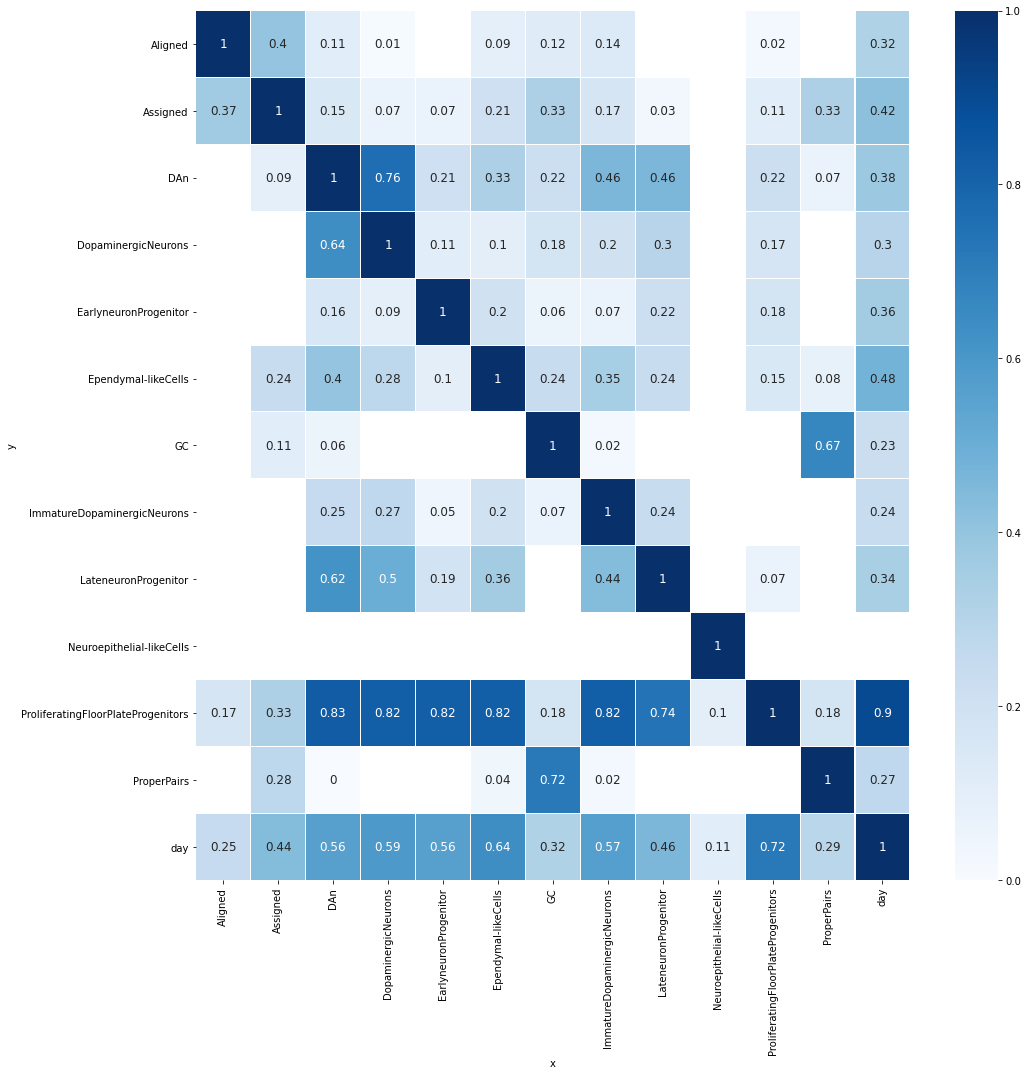

In [33]:
plt.figure(figsize=(16,16)) 
sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.05, 
            annot=True, annot_kws={"fontsize":12})
plt.show()

In [34]:
temp_df = info_df[list(set(cfrac_covs) | set(cfracs_df.columns))]
cats_df = temp_df.select_dtypes(include=['object'])
print(cats_df.shape)
dums_df = pd.get_dummies(cats_df)
print(dums_df.shape)

covs_df = temp_df.merge(dums_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)

(305, 1)
(305, 3)
(305, 16)


(15, 15)


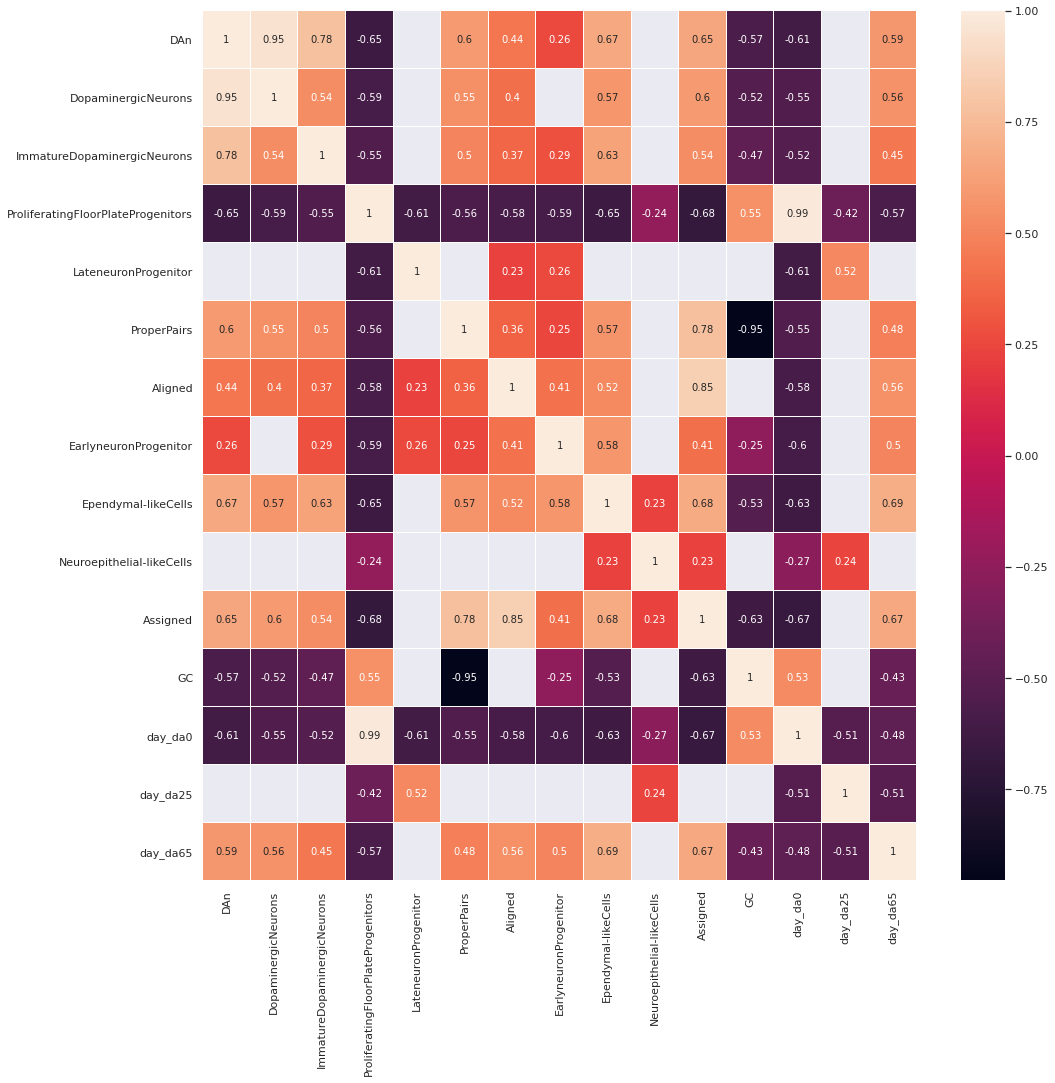

In [35]:
sns.set()
cor = covs_df.corr(method='pearson')
cor.dropna(how='all', inplace=True)
print(cor.shape)
plt.figure(figsize=(16,16))        
sns.heatmap(cor[(cor > 0.22) | (cor < -0.22)], annot=True, annot_kws={"fontsize":10}, \
            linewidths=0.05)    
plt.show()

In [36]:
# a lot of warning can be generated related to number of members and n_splits=4
# so temp supress warnings
warnings.filterwarnings('ignore')

matrix_df = pps.matrix(info_df)
matrix_df = matrix_df.loc[matrix_df['ppscore'] > 0]
print(matrix_df.shape)

default_max_rows = pd.get_option('display.max_rows')
pd.set_option('display.max_rows', 100)
display(matrix_df)
pd.set_option('display.max_rows', default_max_rows)

# restore defaults warning setting
# warnings.filterwarnings('default')
warnings.filterwarnings('once')

(5944, 9)


,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,sampleid,sampleid,1.000000,predict_itself,True,None,0.000000,1.000000,None
1,sampleid,cdi,0.960320,classification,True,weighted F1,0.008071,0.960640,DecisionTreeClassifier()
3,sampleid,version,0.171090,classification,True,weighted F1,0.812564,0.844632,DecisionTreeClassifier()
4,sampleid,Batch,0.995516,classification,True,weighted F1,0.265574,0.996707,DecisionTreeClassifier()
5,sampleid,PPMI_ID,0.995578,classification,True,weighted F1,0.008071,0.995614,DecisionTreeClassifier()
...,...,...,...,...,...,...,...,...,...
9795,DAn,ImmatureDopaminergicNeurons,0.245622,regression,True,mean absolute error,0.062106,0.046852,DecisionTreeRegressor()
9796,DAn,ProliferatingFloorPlateProgenitors,0.830920,regression,True,mean absolute error,0.307501,0.051992,DecisionTreeRegressor()
9797,DAn,LateneuronProgenitor,0.616940,regression,True,mean absolute error,0.199927,0.076584,DecisionTreeRegressor()
9798,DAn,Ependymal-likeCells,0.404199,regression,True,mean absolute error,0.006479,0.003860,DecisionTreeRegressor()


In [37]:
matrix_df['ppscore'] = matrix_df['ppscore'].round(2)
plot_matrix_df = matrix_df[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
print(plot_matrix_df.shape)
display(plot_matrix_df)

(99, 99)


/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


x,AGE_ONSET,AGE_enroll,Aligned,Aligned.1,Alternate MRN,Assigned,BIRTHDT,Barcode_DZNE,Barcode_LNG,Batch,...,pheno,prodromal_category,race,sampleid,sex,study_arm,version,visit_month,visit_name,wgsid
y,,,,,,,,,,,,,,,,,,,,,
AGE_ONSET,1.00,0.99,NaN,NaN,0.77,NaN,0.86,0.77,0.77,0.08,...,NaN,NaN,NaN,0.96,NaN,0.01,NaN,NaN,NaN,0.97
AGE_enroll,0.96,1.00,NaN,NaN,0.79,NaN,0.79,0.79,0.79,0.03,...,NaN,NaN,NaN,0.99,NaN,0.02,0.00,NaN,NaN,0.99
Aligned,NaN,NaN,1.00,NaN,NaN,0.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aligned.1,0.03,NaN,NaN,1.0,0.00,NaN,NaN,0.00,0.00,0.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alternate MRN,0.95,0.81,0.00,0.0,1.00,NaN,0.22,1.00,1.00,0.11,...,0.00,0.02,0.00,0.99,0.02,0.08,0.03,0.0,0.0,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
study_arm,1.00,0.80,0.01,NaN,0.83,NaN,0.38,0.83,0.83,0.06,...,0.28,NaN,NaN,0.92,0.05,1.00,NaN,NaN,NaN,0.92
version,0.19,0.15,NaN,NaN,0.17,NaN,0.08,0.17,0.17,0.00,...,0.00,0.00,0.00,0.17,0.00,0.00,1.00,0.0,0.0,0.19
visit_month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [38]:
# plt.figure(figsize=(24,20)) 
# sns.heatmap(plot_matrix_df, vmin=0, vmax=1, cmap="Blues", linewidths=0.05, 
#             annot=True, annot_kws={"fontsize":10})
# plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
info_df.select_dtypes(include=['object']).columns

Index(['sampleid', 'cdi', 'day', 'version', 'Batch', 'PPMI_ID', 'DZNE_Barcode',
       'DZNE_ID', 'Culture_Media_iPSC', 'Growth_iPSC',
       'Spontaneous_differentiation', 'Differentiation_Start',
       'participant_id', 'visit_name', 'sex', 'ethnicity_x', 'race',
       'education_level_years', 'diagnosis_at_baseline', 'diagnosis_latest',
       'case_control_other_at_baseline', 'case_control_other_latest',
       'study_arm', 'prodromal_category', 'Recruitment', 'wgsid', 'RECRUIT',
       'DX_INIT', 'DIAG', 'RECRUITMENT_CAT', 'IMAGING_CAT', 'ENROLL_CAT',
       'DESCRP_CAT', 'pheno', 'Barcode_LNG', 'Barcode_DZNE', 'Alternate MRN',
       'IID', 'mutation', 'Relatives', 'FID', 'GROUP'],
      dtype='object')

In [40]:
# cats_df = info_df.select_dtypes(include=['object'])
cats_df = info_df[['day', 'version', 'Batch', 'Culture_Media_iPSC', 'Growth_iPSC',
                   'Spontaneous_differentiation', 'Differentiation_Start',
                   'visit_name', 'sex', 'ethnicity_x', 'race',
                   'education_level_years', 'diagnosis_at_baseline', 
                   'diagnosis_latest', 'case_control_other_at_baseline', 
                   'case_control_other_latest', 'study_arm', 'prodromal_category', 
                   'Recruitment', 'RECRUIT', 'DX_INIT', 'DIAG', 'RECRUITMENT_CAT', 
                   'IMAGING_CAT', 'ENROLL_CAT', 'DESCRP_CAT', 'pheno',
                   'mutation', 'Relatives', 'GROUP']]
print(cats_df.shape)
dums_df = pd.get_dummies(cats_df)
print(dums_df.shape)

covs_df = info_df.merge(dums_df, how='inner', left_index=True, right_index=True)
print(covs_df.shape)

(305, 30)
(305, 151)
(305, 250)


(207, 208)


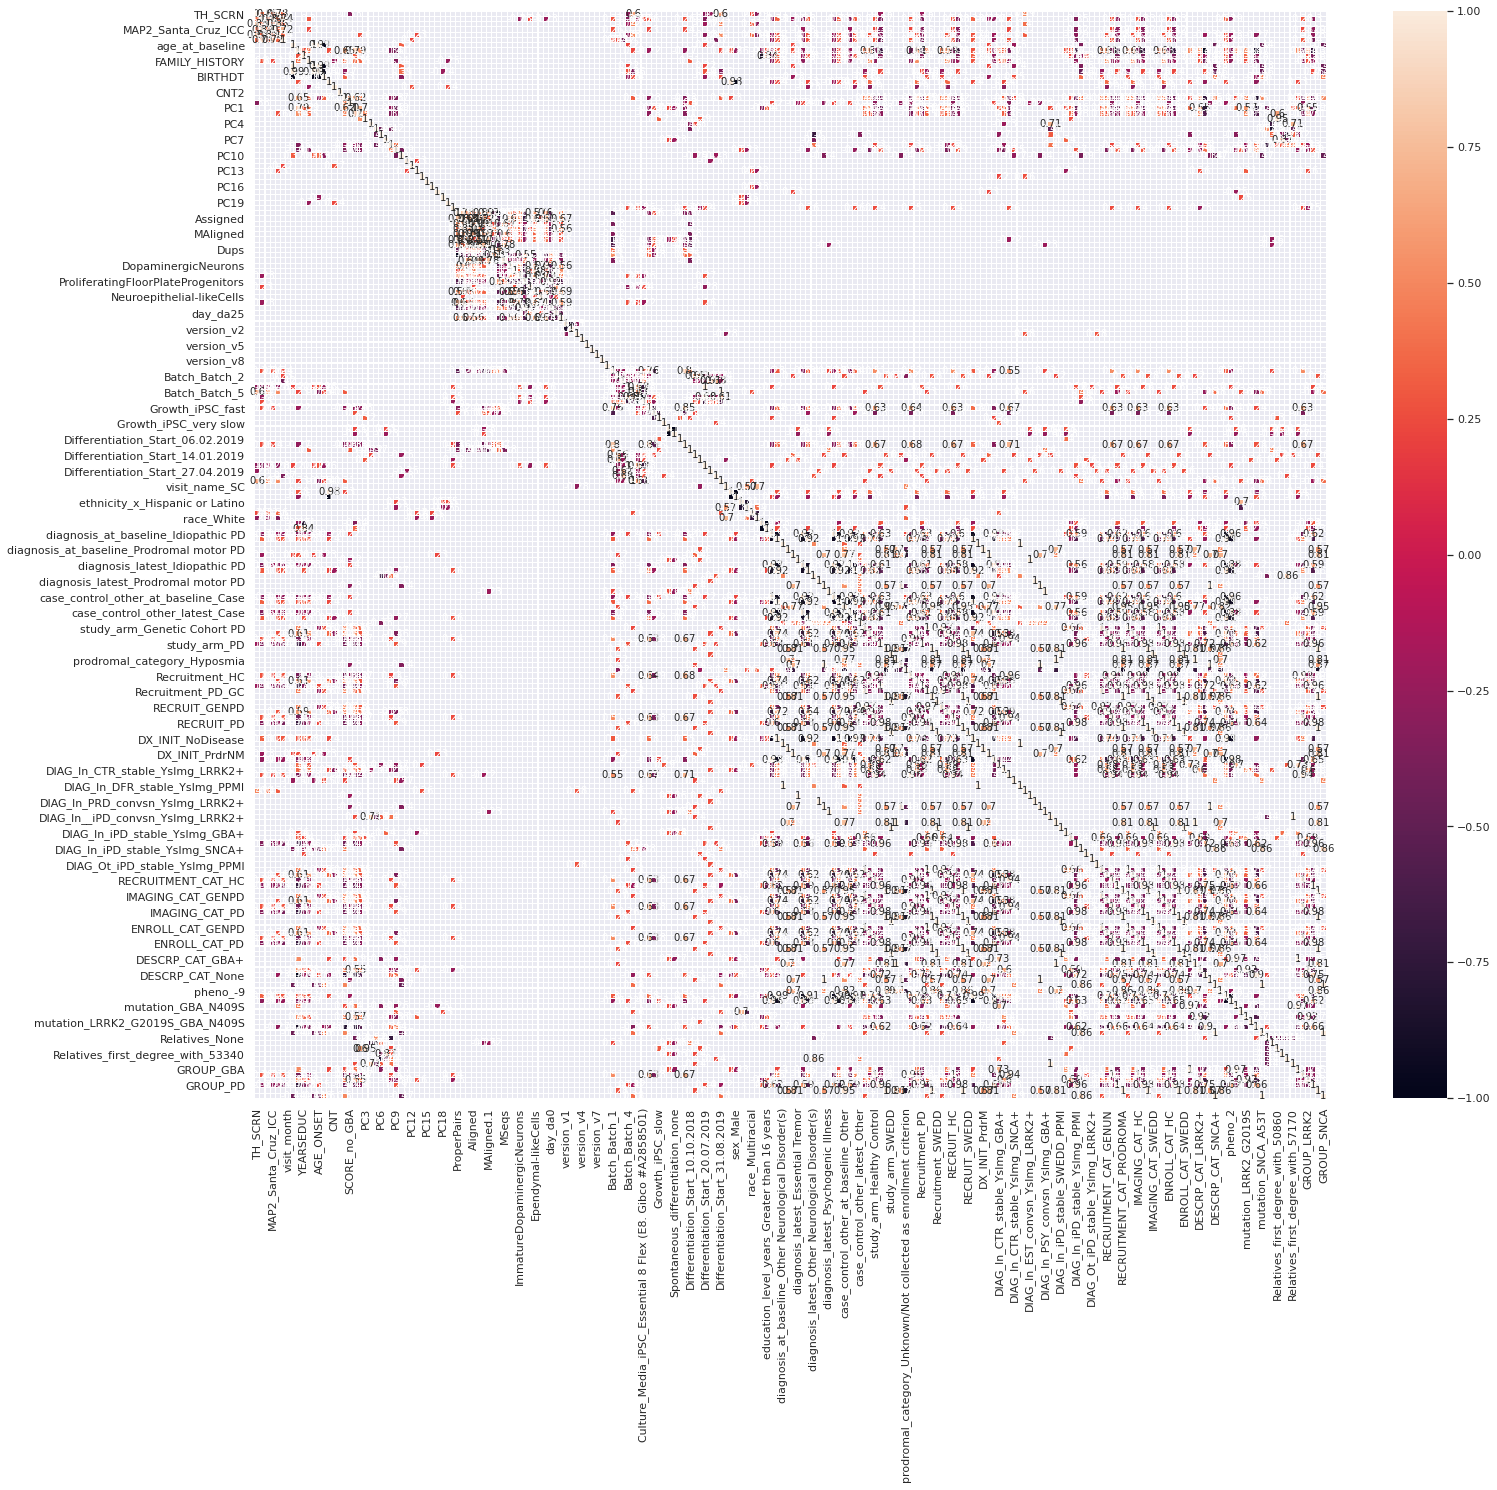

In [41]:
sns.set()
cor = covs_df.corr(method='pearson')
cor.dropna(how='all', inplace=True)
print(cor.shape)
plt.figure(figsize=(24,20))        
sns.heatmap(cor[(cor > 0.22) | (cor < -0.22)], annot=True, annot_kws={"fontsize":10}, \
            linewidths=0.05)
# sns.heatmap(cor[(cor > 0.1) | (cor < -0.1)], annot=True, annot_kws={"fontsize":12}, \
#             linewidths=0.05)
plt.show()